In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta

In [179]:
#UTILS 
def ret_metrics(daily_ret_df):
    start_date, end_date = daily_ret_df.index[[0,-1]]
    years = (end_date - start_date).days/365
    
    #CGR
    CGR = (1 + daily_ret_df).cumprod() - 1
    CAGR = (CGR[-1] + 1)**(1/years) - 1
    
    #Information Ratios
    sharpe = daily_ret_df.mean()/daily_ret_df.std()
    rolling_sharpe = daily_ret_df.rolling(window=126).mean()/daily_ret_df.rolling(window=126).std()

    #Drawdown
    roll_max = (1+CGR).cummax()
    drawdown = (1+CGR)/roll_max - 1.0
    max_drawdown= drawdown.min()
    drawdown_times = (drawdown < 0).astype(np.int64)
    max_drawdown_duration = drawdown_times.groupby((drawdown_times != drawdown_times.shift()).cumsum()).cumsum().min()
    
    #Win/Loss percentage
    winners = (daily_ret_df > 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    losers = (daily_ret_df < 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    
    print(f'CAGR: {np.round(100*CAGR,2)}% \nAnnual Sharpe Ratio: {round(252**0.5 * sharpe,2)} \
          \nWin Percetage: {np.round(100*winners, 2)}% \
          \nLoss Percetage: {np.round(100*losers, 2)}% \
          \nMax win: {np.round(100*daily_ret_df.max(),2)}% \
          \nMax Loss: {np.round(100*daily_ret_df.min(),2)}% \
          \nAverage Win/Loss: {np.round(100*daily_ret_df.mean(), 2)}% \
          \nMax Drawdown: {np.round(100*max_drawdown,2)}% \
          \nMax Drawdown Duration: {max_drawdown_duration} \
          \n\n')
    
    CGR.plot()
    plt.title('Cummulative Growth')
    plt.show()
    
    drawdown.plot()
    plt.title('Drawdown')
    plt.show()
    return drawdown
def all_strats(daily_rets, weights):
    if np.sum(weights) != 1:
        raise ValueError('Weights do not add to 1')
    total_daily_rets = 0
    for i in range(len(daily_rets)):
        total_daily_rets = total_daily_rets + daily_rets[i]*weights[i]
    return total_daily_rets

In [ ]:
tickers = ""
symbols = pd.read_csv('bats_symbols.csv')['Name']
for symbol in symbols:
    tickers += " " +symbol
tickers = tickers[1:]
data = yf.Tickers(tickers)
history = data.history(start='2015-04-04', end='2017-05-01')

In [168]:
#Market ret as mean
cl = history['Close']
ret = cl.pct_change()
ret = ret.drop('BOSS', axis=1)

market_ret = ret.mean(axis=1) #unweighted
weights = - ret.add(- market_ret, axis=0)
weights = weights.div(abs(weights).sum(axis=1), axis = 0)

#Dont trade if the daily ret is too high
inds = abs(market_ret)>0.01
weights[inds] = 0

dailyret_1 = (weights.shift(1)*ret).sum(axis=1, skipna=True)
#kelly = 0.25*(dailyret.rolling(window=63).mean()/dailyret.rolling(window=63).var())
#kelly[kelly >= max_leverage] = max_leverage
#dailyret = kelly.shift*(1)*dailyret

#ret_metrics(dailyret)

In [169]:
op = history['Open']
cl = history['Close']

ret = (op - cl.shift(1))/cl.shift(1)
ret = ret.drop('BOSS', axis=1)

market_ret = ret.mean(axis=1)
weights = - ret.add(- market_ret, axis=0)
weights = weights.div(abs(weights).sum(axis=1), axis = 0)

inds = abs(market_ret)>0.01
weights[inds] = 0

dailyret_2 = (weights*(cl-op)/op).sum(axis=1, skipna=True).div(abs(weights).sum(axis=1), axis=0) 
kelly = 0.25*(dailyret.rolling(window=63).mean()/dailyret.rolling(window=63).var())

max_leverage = 4
kelly[kelly >= max_leverage] = max_leverage
#dailyret = kelly.shift(1)*dailyret

#ret_metrics(dailyret)

CAGR: 44.07% 
Annual Sharpe Ratio: 2.87           
Win Percetage: 67.58%           
Loss Percetage: 32.42%           
Max win: 7.32%           
Max Loss: -2.93%           
Average Win/Loss: 0.15%           
Max Drawdown: -9.27%           
Max Drawdown Duration: 0           




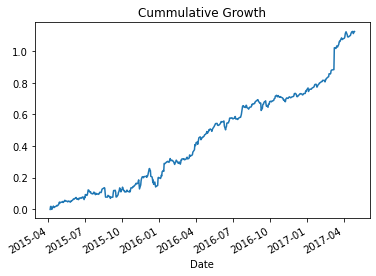

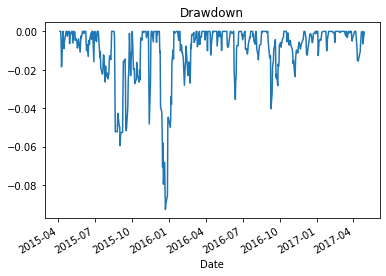

In [180]:
dailyrets = all_strats([dailyret_1, dailyret_2], [0.5, 0.5])
dd = ret_metrics(dailyrets.fillna(0))

<AxesSubplot:xlabel='Date'>

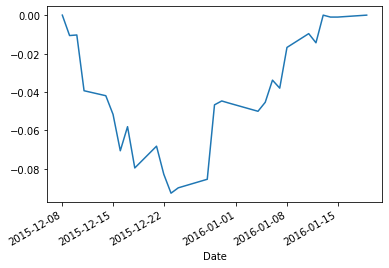

In [211]:
dd[172:200].plot()

In [192]:
(dd>=0).astype(np.int64).groupby('Date').agg(lambda x: x.ne(0).sum()).head(10)

Date
2015-04-06    1
2015-04-07    1
2015-04-08    1
2015-04-09    0
2015-04-10    0
2015-04-13    0
2015-04-14    1
2015-04-15    0
2015-04-16    0
2015-04-17    0
dtype: int64

9